In [2]:
import appdirs, os

import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

from captum.attr import visualization as viz

import numpy as np
import scipy
from scipy.linalg import orth

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd

from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import os
import random

from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

import util
from util import compute_tangent_space, project_into_tangent_space, normalize_image, dcn

from models import resnet18_and_optimizer

from MNIST32 import MNIST256

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# note: the bilinear upsampling used here reduces the numeric dimension of the tangent space to 8
IMG_DIM = 256

In [4]:
def model_and_optimizer():
    return resnet18_and_optimizer(lr=1e-2)

## Draw a fixed batch of data on which we evaluate the model during training

In [5]:
z_monitor, x_monitor, c_monitor, t_monitor = pkl.load(open('./output/mnist_monitor_256_batch_10000.pkl', 'rb'))
z_monitor = z_monitor[:len(t_monitor)]
x_monitor = x_monitor[:len(t_monitor)]
c_monitor = c_monitor[:len(t_monitor)]
print(len(t_monitor))

317


In [10]:
for tsp in t_monitor[:10]:
    print(tsp.shape)

(8, 256, 256)
(7, 256, 256)
(8, 256, 256)
(8, 256, 256)
(7, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)
(8, 256, 256)


## Data

In [8]:
"""
from torchvision.datasets import ImageFolder
from torchvision.transforms import Lambda

streaming_data = False
transform = transforms.Compose([transforms.ToTensor(),
                                Lambda(lambda x: x[0, :, :].unsqueeze(0))])    # we only want a single input channel

trainset = ImageFolder('data/MNIST256', transform=transform)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
testset = ImageFolder('data/MNIST256_Val', transform=transform)
testloader = DataLoader(testset, batch_size=8, shuffle=True)
"""

In [7]:
trainset = torch.utils.data.TensorDataset(*torch.load('/mnt/qb/luxburg/sbordt10/explanations-manifold/data/MNIST256_train.pkl'))
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)

testset = torch.utils.data.TensorDataset(*torch.load('/mnt/qb/luxburg/sbordt10/explanations-manifold/data/MNIST256_val.pkl'))
testloader = DataLoader(testset, batch_size=8, shuffle=True)

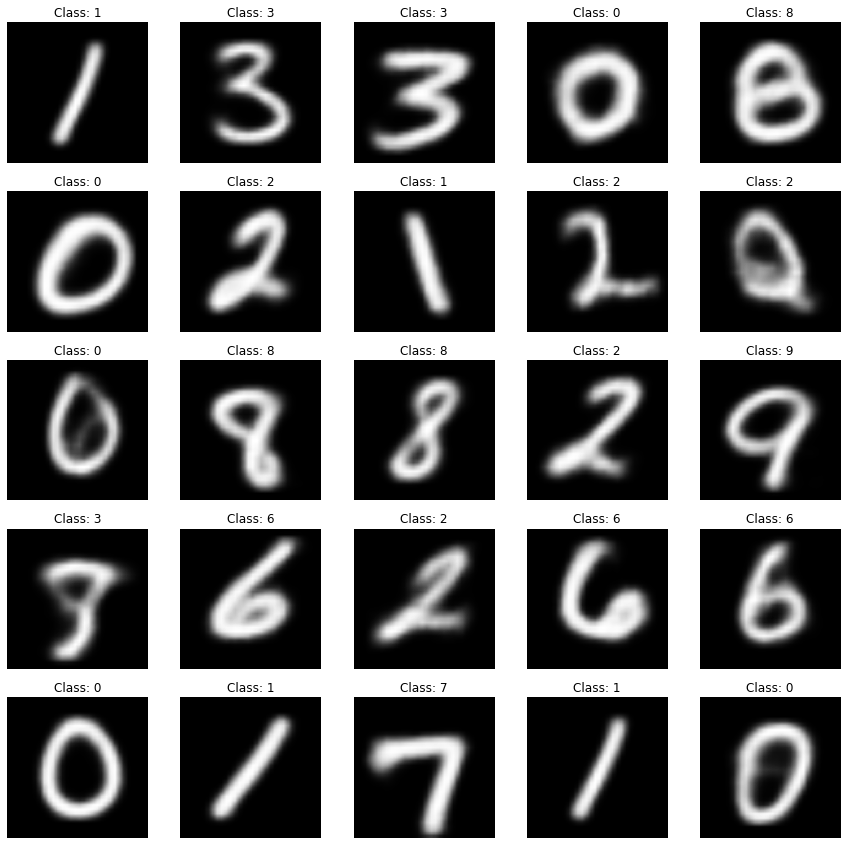

In [8]:
fix, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        img, c = iter(trainloader).__next__()
        axs[i,j].imshow(dcn(img[0, 0, :, :]), cmap='gray', interpolation='none')
        axs[i,j].set_title(f'Class: {c[0]}')
        axs[i,j].axis('off')
plt.show()

## Train a Resnet18

#### monitor how class gradients evolve during training

In [8]:
model, optimizer = model_and_optimizer()

In [10]:
# decrease the learning rate over time
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [11]:
gradient_steps_to_monitor = list(range(21))
gradient_steps_to_monitor.extend([25*i for i in range(1, 25)])
gradient_steps_to_monitor.extend([600 + 100*i for i in range(1, 15)])
gradient_steps_to_monitor.extend([2000 + 1000*i for i in range(1, 100)])

In [12]:
N = 250 # size of evaluation dataset
inputs = [x_monitor[i, :, :, :] for i in range(N)]
model.to(device)
ce_loss = torch.nn.CrossEntropyLoss()
num_gradient_steps = 0
gradient_step_monitoring = {}

for i_epoch in range(50):    
    # gradient descent on the dataset
    ce_loss = torch.nn.CrossEntropyLoss()
    model.train()
    train_loss = 0
    train_zero_one_loss = 0
    for img, label in trainloader:
        # monitoring
        if num_gradient_steps in gradient_steps_to_monitor: 
            print(f'Monitoring after {num_gradient_steps} gradient steps.')
            grad_list, int_grad_list, igx_list = util.compute_saliency_maps(model, inputs)
            smooth_grad_list = [util.smooth_grad(model, img, 0.02, 25) for img in inputs]
            # compute and store fractions
            test_zero_one_loss = util.test(model, testloader, device, verbose=False)
            frac_grad_its = util.tangent_space_ratio(grad_list, t_monitor[:N])
            frac_smooth_grad_its = util.tangent_space_ratio(smooth_grad_list, t_monitor[:N])
            frac_int_grad_its = util.tangent_space_ratio(int_grad_list, t_monitor[:N]) 
            frac_ixg_its = util.tangent_space_ratio(igx_list, t_monitor[:N])
            gradient_step_monitoring[num_gradient_steps] = [np.mean(frac_grad_its), 
                                                            np.mean(frac_smooth_grad_its), 
                                                            np.mean(frac_int_grad_its), 
                                                            np.mean(frac_ixg_its),
                                                            test_zero_one_loss]
            # TMP save what we got 
            torch.save(gradient_step_monitoring, './output/mnist256_resnet_gradient_step_monitoring')
            torch.save(model.state_dict(), './models/mnist256_resnet.pth')
            # resume training 
            model.train()
            
        # take a single gradient step
        img, label = img.to(device), label.to(device)
        pred = model(img)
        optimizer.zero_grad()
        loss = ce_loss(pred, label)
        loss.backward()
        train_loss += loss.item()  
        train_zero_one_loss += (pred.softmax(dim=1).argmax(dim=1) != label).sum().item()
        optimizer.step()
        num_gradient_steps += 1
    train_zero_one_loss = train_zero_one_loss / len(trainloader.dataset)
    print('Train Error: ', train_zero_one_loss)
    
    util.test(model, testloader, device)
    scheduler.step()

Train Error:  0.06656666666666666
Test Error:  0.0286
Train Error:  0.025616666666666666
Test Error:  0.0168
Train Error:  0.018833333333333334
Test Error:  0.0225
Train Error:  0.016083333333333335
Test Error:  0.0123
Train Error:  0.0146
Test Error:  0.0159
Train Error:  0.012416666666666666
Test Error:  0.0143
Train Error:  0.0112
Test Error:  0.0151
Train Error:  0.010283333333333334
Test Error:  0.0108
Train Error:  0.009083333333333334
Test Error:  0.0134
Train Error:  0.008333333333333333
Test Error:  0.0137
Train Error:  0.002683333333333333
Test Error:  0.0083
Train Error:  0.0012333333333333332
Test Error:  0.0079
Train Error:  0.0007333333333333333
Test Error:  0.008


KeyboardInterrupt: 

In [ ]:
torch.save(gradient_step_monitoring, './output/mnist256_resnet_gradient_step_monitoring')

In [13]:
torch.save(model.state_dict(), './models/mnist256_resnet.pth')

# Quantitative Evaluation: Histograms with fraction in tangent space for different methods

In [43]:
from captum.attr import LayerGradCam, LayerAttribution

In [76]:
def layer_grad_cam(model, img, target=None, device='cuda'):
    '''
    NOTE: computation takes place on the given device, but the output will be on the cpu
    '''
    model.eval()
    if len(img.shape) == 2:     # expand to 4 dimensions
        img = img.unsqueeze(0)
    if len(img.shape) == 3:
        img = img.unsqueeze(0)
    img = img.to(device)
    img.requires_grad_(True)
    if img.grad is not None:
        img.grad.zero_()
    if target is None: # predicted class
        pred = model(img)
        target = pred[0].argmax().item()      
    layer_gc = LayerGradCam(model, model.layer4[1].conv2)
    int_grad = layer_gc.attribute(img, target)
    int_grad = deepcopy(dcn(int_grad).squeeze())        
    return int_grad

gc_attr = layer_grad_cam(model, inputs[0])

In [9]:
# load a previously trained model
model, _ = model_and_optimizer()
model.load_state_dict(torch.load('./models/mnist256_resnet.pth'))
model.to(device)
model.eval()
util.test(model, testloader, device)

Test Error:  0.0081


0.0081

In [118]:
inputs = [x_monitor[i, :, :, :] for i in range(len(t_monitor))]

In [94]:
grad_list, int_grad_list, igx_list = util.compute_saliency_maps(model, inputs)

900it [01:34,  9.49it/s]


In [95]:
smooth_grad_list = [util.smooth_grad(model, img, 0.02, 25) for img in inputs]

In [15]:
random_vectors_list = [np.mean(np.abs(np.array(grad_list))) + np.random.normal(size = grad_list[0].shape) for _ in range(len(t_monitor))]

In [119]:
grad_cam_list = [layer_grad_cam(model, img) for img in inputs]
grad_cam_list = [cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC) for img in grad_cam_list]

In [120]:
frac_grad_cam_its = util.tangent_space_ratio(grad_cam_list, t_monitor)
np.mean(frac_grad_cam_its)

0.5297715550856161

In [97]:
#frac_random_its = util.tangent_space_ratio(random_vectors_list, t_monitor)
frac_grad_its = util.tangent_space_ratio(grad_list, t_monitor)
frac_smooth_grad_its = util.tangent_space_ratio(smooth_grad_list, t_monitor)
frac_int_grad_its = util.tangent_space_ratio(int_grad_list, t_monitor) 
frac_ixg_its = util.tangent_space_ratio(igx_list, t_monitor)

In [28]:
torch.save((frac_grad_its, frac_smooth_grad_its, frac_int_grad_its, frac_ixg_its), './output/mnist256_figure_data.pkl')

In [ ]:
np.mean(frac_grad_its), np.mean(frac_smooth_grad_its), np.mean(frac_int_grad_its), np.mean(frac_ixg_its)

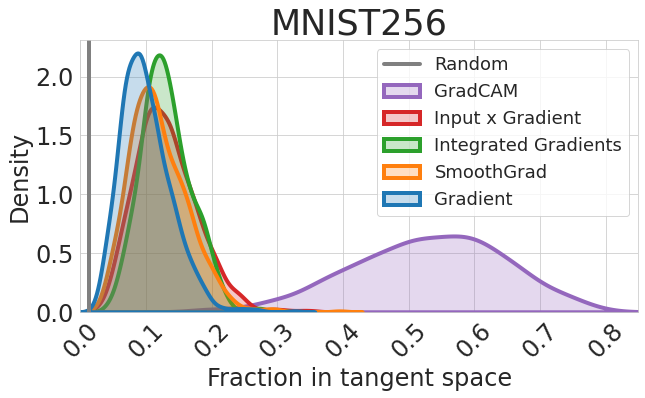

In [124]:
val_pair = []
for v in frac_grad_its:
    val_pair.append((v, 'Gradient'))
for v in frac_smooth_grad_its:
    val_pair.append((v, 'SmoothGrad'))
for v in frac_int_grad_its:
    val_pair.append((v, 'Integrated Gradient'))
for v in frac_ixg_its:
    val_pair.append((v, 'Input X Gradient'))
for v in frac_grad_cam_its:
    val_pair.append((v, 'GradCAM'))
df = pd.DataFrame(data=val_pair, columns=['Value', 'Method'])
sns.set_style('whitegrid')

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='Value', hue='Method', fill=True, legend=False, lw=4, alpha=0.25)
plt.axvline(np.sqrt(10 / 256**2), 0, 1.4, label='Random', color='gray', lw=4)
plt.legend(labels=['Random', 'GradCAM', 'Input x Gradient', 'Integrated Gradients', 'SmoothGrad', 'Gradient'], fontsize=18) #  , loc='upper left'
plt.xlim([0., 0.85])
plt.xticks(fontsize=24, rotation=45)
plt.xlabel('Fraction in tangent space', fontsize=24)
#plt.xlabel('', fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Density', fontsize=24)
#plt.ylabel('', fontsize=24)
plt.title('MNIST256', fontsize=35)
plt.savefig('mnist_256_methods.pdf', bbox_inches='tight')
plt.show()

# Qualitative Evaluation: Saliency Maps that lie in tangent space versus those that don't

In [26]:
predictions = []
for x in tqdm(x_monitor):
    img = dcn(x)
    pred = model(torch.tensor(img).unsqueeze(0).cuda()).argmax().item()
    predictions.append(pred)
predictions = torch.tensor(predictions)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 317/317 [00:00<00:00, 348.73it/s]


In [50]:
def plot_saliency_with_image_contour(ax, img, smap, vmin, vmax):
    ''' Plot the saliency map with an overlayed image contour.
    '''
    img = np.array(1-img.squeeze())
    img_edges = feature.canny(img, sigma=1.5) # changed parameter due to different dimension
    x = np.zeros((IMG_DIM, IMG_DIM, 4))
    for i in range(3):
        x[ :, :, i] = 1-img_edges
    x[ :, :, 3] = img_edges 
    ax.imshow(smap, vmin=vmin, vmax=vmax, cmap='bwr')
    ax.imshow(x, cmap='gray')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

In [51]:
def visualize(model, images, explanations, tangent_spaces, p=0.005):
    '''
        First row: images
        second row: part of gradient in tangent space
        third row: part of gradient orthogonal to the tangent space
        
        TODO change the interface of this function, model is not really required, only used to compute prediction
    '''
    sns.set_style('white')
    fig, axs = plt.subplots(3, 10, figsize=(20, 6))
    for i in range(10):
        img = images[i]
        grad = explanations[i]
        tangent_space = tangent_spaces[i]
        
        # tangent space decomposition
        grad_in_tangent_space = util.project_into_tangent_space(tangent_space, grad)
        grad_not_in_tangnet_space = grad-grad_in_tangent_space
        pred = model(img.unsqueeze(0).cuda()).argmax().item()
        ratio = np.linalg.norm(grad_in_tangent_space.flatten())/np.linalg.norm(grad.flatten())

        # normalize vectors
        grad = grad / np.linalg.norm(grad.flatten())
        grad_in_tangent_space = grad_in_tangent_space / np.linalg.norm(grad_in_tangent_space.flatten())
        grad_not_in_tangnet_space = grad_not_in_tangnet_space / np.linalg.norm(grad_not_in_tangnet_space.flatten())
        
        # clip the p-percent larget values off
        pooled_vectors = np.array((grad, grad_in_tangent_space, grad_not_in_tangnet_space)).flatten().squeeze()
        quantile = np.quantile(abs(pooled_vectors), 1-p)
        
        grad[np.where(grad > quantile)] = quantile
        grad[np.where(grad < -quantile)] = -quantile
        grad_in_tangent_space[np.where(grad_in_tangent_space > quantile)] = quantile
        grad_in_tangent_space[np.where(grad_in_tangent_space < -quantile)] = -quantile
        grad_not_in_tangnet_space[np.where(grad_not_in_tangnet_space > quantile)] = quantile
        grad_not_in_tangnet_space[np.where(grad_not_in_tangnet_space < -quantile)] = -quantile
        
        # adjust color space
        v = max([max(abs(x.min()), x.max()) for x in [grad, grad_in_tangent_space, grad_not_in_tangnet_space]])

        # the image
        axs[0, i].imshow(1-img.squeeze(), cmap='gray', interpolation='none')
        plt.setp(axs[0, i].get_xticklabels(), visible=False)
        plt.setp(axs[0, i].get_yticklabels(), visible=False)
        axs[0, i].set_title(f'Prediction: {pred}')
        
        # saliency maps
        #plot_saliency_with_image_contour(axs[1, i], img, grad, -v, v)
        plot_saliency_with_image_contour(axs[1, i], img, grad_in_tangent_space, -v, v)
        plot_saliency_with_image_contour(axs[2, i], img, grad_not_in_tangnet_space, -v, v)
    plt.show()

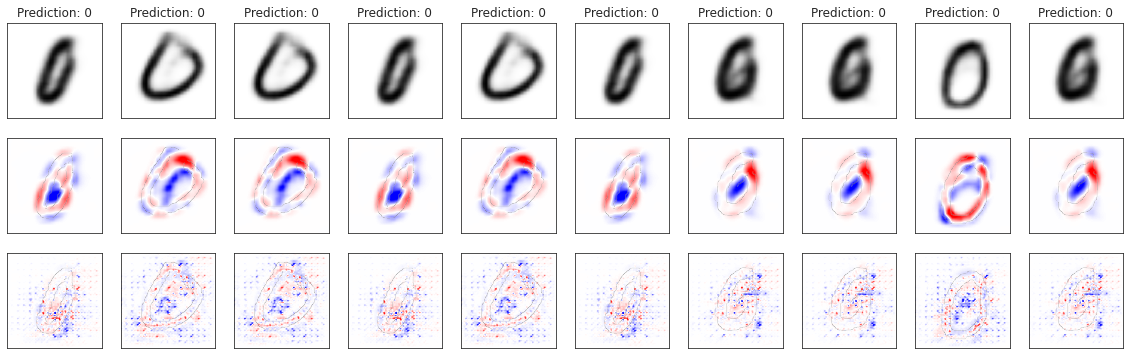

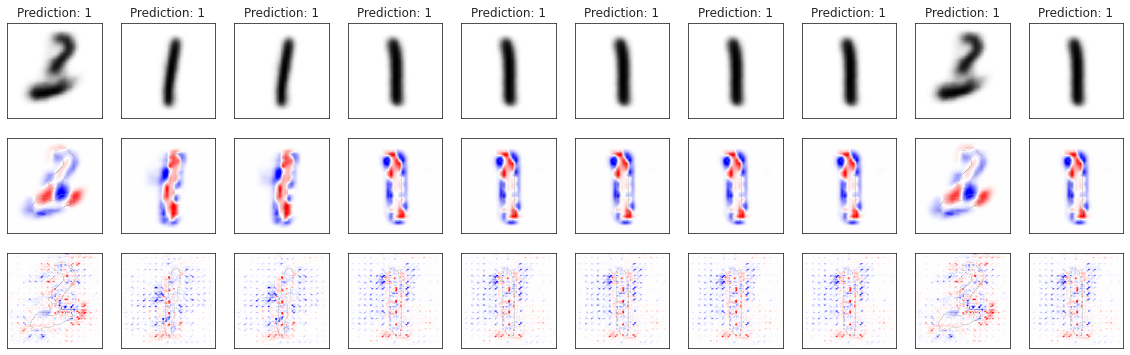

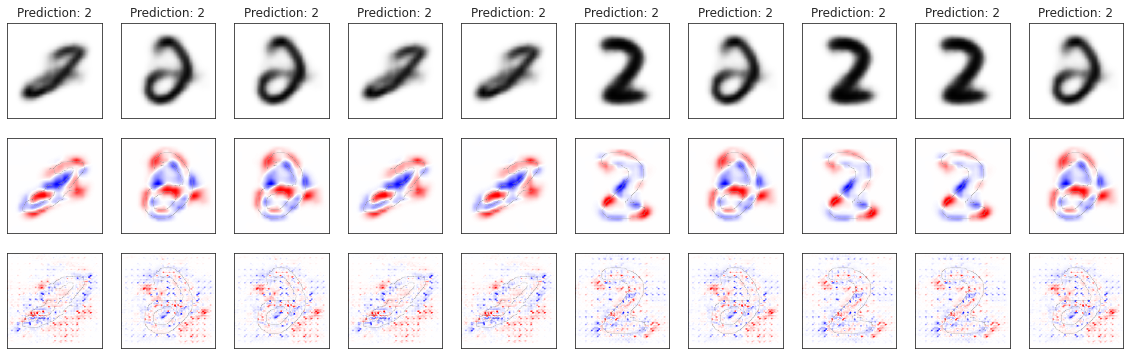

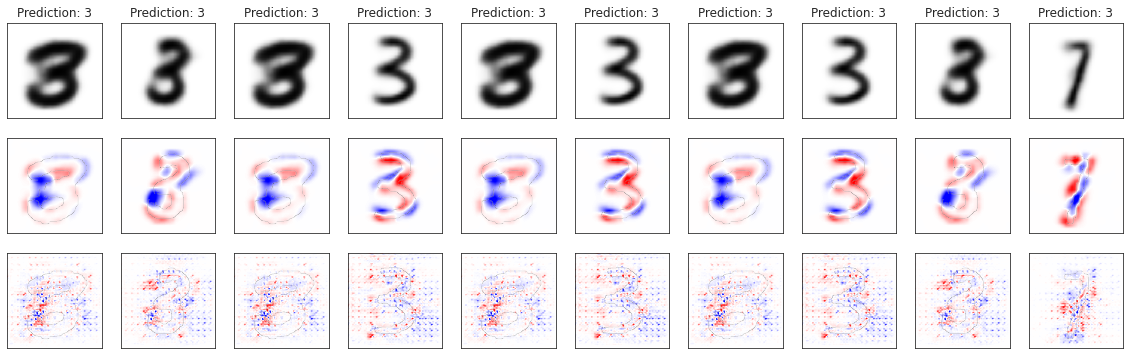

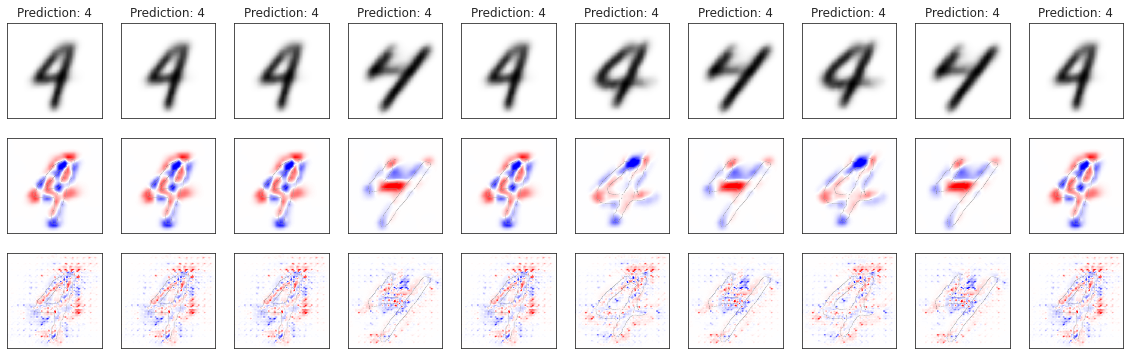

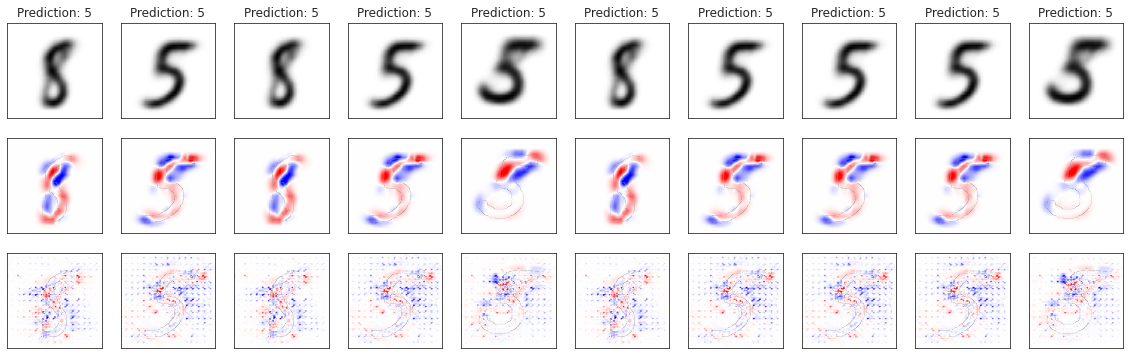

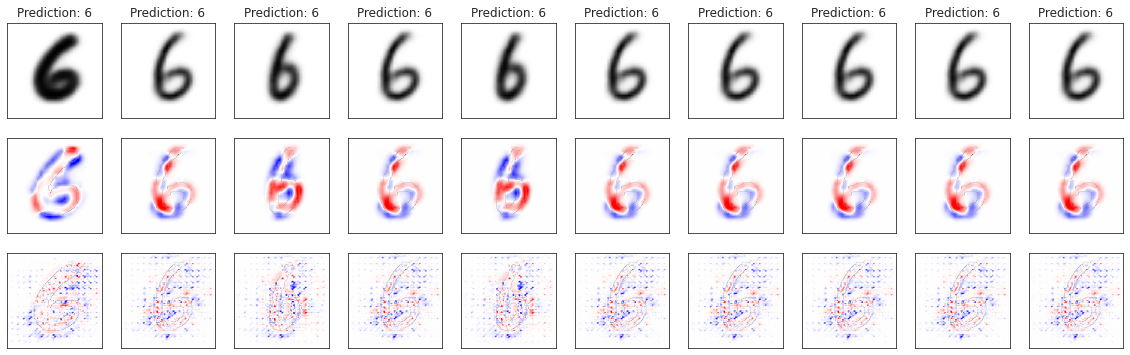

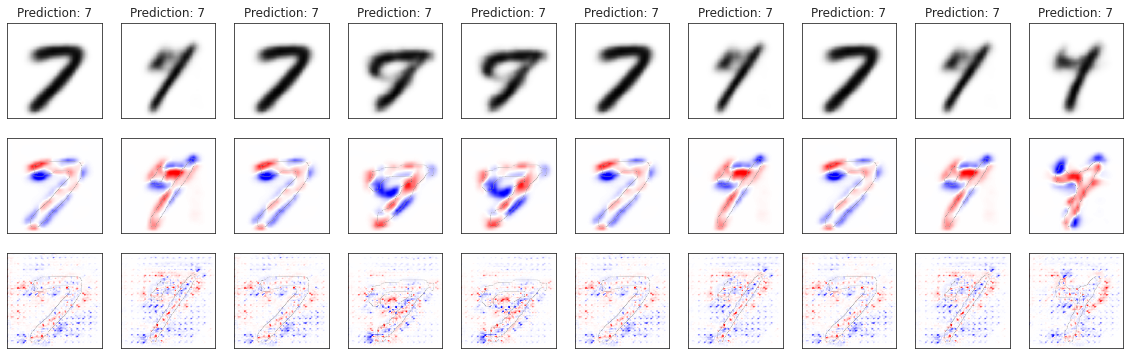

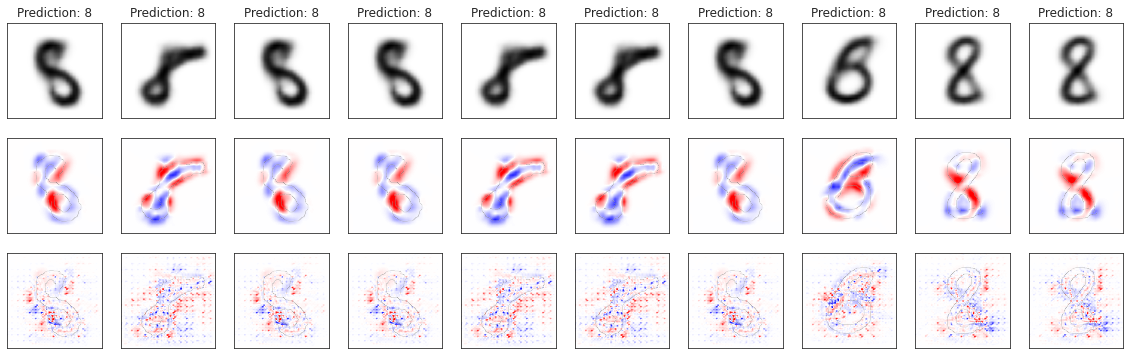

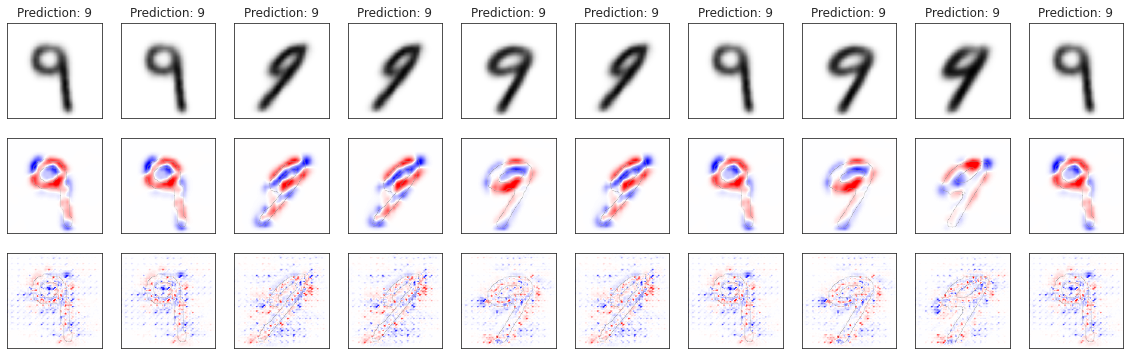

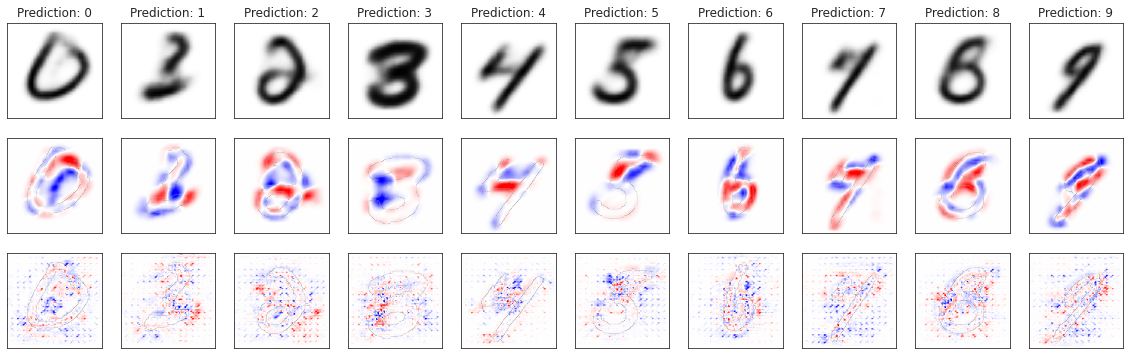

In [52]:
# correct predictions with largest fraction in tangent space
class_max_indices = []
for c in range(10):
    class_indices = np.where(c_monitor == c)[0]           # indices where the true class is c
    class_quantile = np.quantile(np.array(frac_grad_its)[class_indices], 0.9)
    pred_indices = np.where(predictions == c)[0]          # indices where we predicted class c
    indices = np.where(np.array(frac_grad_its) > class_quantile)[0] # where the fraction in tangent space is additionally larger than the class-quantile
    indices = list(set(indices).intersection(class_indices))
    indices = list(set(indices).intersection(pred_indices))  # indices where we correctly predicted class c
    indices = np.random.choice(indices, size=10, replace=True if len(t_monitor) < 5000 else False)
    visualize(model, [inputs[i] for i in indices], [grad_list[i] for i in indices], [t_monitor[i] for i in indices])    
    # the picture in the class that has the largest fraction in tangent space
    class_max_indices.append(np.where(frac_grad_its == max(np.array(frac_grad_its)[indices]))[0][0])
visualize(model, [inputs[i] for i in class_max_indices], [grad_list[i] for i in class_max_indices], [t_monitor[i] for i in class_max_indices])    